In [1]:
import sys, os

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join
import h5py
import warnings
import gc

import scmomat 

plt.rcParams["font.size"] = 10
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def wrap_warn_comp_plot(ads, basis, colors, figw=5, figh=4, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, color in enumerate(colors):
            _, axes = plt.subplots(1, len(ads), figsize=(figw*len(ads), figh))
            for j, ad in enumerate(ads):
                sc.pl.embedding(ad, basis=basis, color=color, ax=axes[j], show=False, **kwargs)
            plt.show()
            
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2


In [14]:
def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v
    
def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def flip_coords(ads):
    for ad in ads:
        ad.obsm['spatial'] = -1 * ad.obsm['spatial']
        ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]

def reorder(ad1, ad2):
    shared_barcodes = ad1.obs_names.intersection(ad2.obs_names)
    ad1 = ad1[shared_barcodes].copy()
    ad2 = ad2[shared_barcodes].copy()
    return ad1, ad2

def load_peak_expr(_dir):
    data = sio.mmread(join(_dir, 'data.mtx'))
    cname = pd.read_csv(join(_dir, 'barcode.csv'), index_col=0)['x'].to_list()
    feat = pd.read_csv(join(_dir, 'feat.csv'), index_col=0)['x'].to_list()
    ad = sc.AnnData(sps.csr_matrix(data.T))
    ad.obs_names = cname
    ad.var_names = feat
    return ad

def add_name_prefix(list, prefix):
    new_list = [f'{prefix}-{x}' for x in list]
    return new_list

### load dataset

In [4]:
# rna+H3K27me3
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K27me3'
df_mult_rna = pd.read_csv(join(data_dir, 'rna+H3K27me3/GSM6753044_MouseBrain_20um_100barcodes_H3K27me3_matrix.tsv'), sep='\t')
df_mult_rna_spatial = pd.read_csv(join(data_dir, 'rna+H3K27me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna = sc.AnnData(df_mult_rna.T, obsm={'spatial': df_mult_rna_spatial.loc[df_mult_rna.columns, [2, 3]].values})
ad_mult_rna.layers['counts'] = ad_mult_rna.X.copy()

ad_mult_atac = load_peak_expr(join(data_dir, 'rna+H3K27me3/peak_data'))
df_mult_atac_spatial = pd.read_csv(join(data_dir, 'rna+H3K27me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac.obsm['spatial'] = df_mult_atac_spatial.loc[ad_mult_atac.obs_names, [2, 3]].values
ad_mult_atac.layers['counts'] = ad_mult_atac.X.copy()

ad_mult_rna, ad_mult_atac = reorder(ad_mult_rna, ad_mult_atac)

# rna+H3K4me3
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K4me3'
df_mult_rna2 = pd.read_csv(join(data_dir, 'rna+H3K4me3/GSM6753046_MouseBrain_20um_100barcodes_H3K4me3_matrix.tsv'), sep='\t')
df_mult_rna_spatial2 =pd.read_csv(join(data_dir, 'rna+H3K4me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna2 = sc.AnnData(df_mult_rna2.T, obsm={'spatial': df_mult_rna_spatial2.loc[df_mult_rna2.columns, [2, 3]].values})
ad_mult_rna2.layers['counts'] = ad_mult_rna2.X.copy()

ad_mult_atac2 = load_peak_expr(join(data_dir, 'rna+H3K4me3/peak_data'))
df_mult_atac_spatial2 = pd.read_csv(join(data_dir, 'rna+H3K4me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac2.obsm['spatial'] = df_mult_atac_spatial2.loc[ad_mult_atac2.obs_names, [2, 3]].values
ad_mult_atac2.layers['counts'] = ad_mult_atac2.X.copy()

ad_mult_rna2, ad_mult_atac2 = reorder(ad_mult_rna2, ad_mult_atac2)

# rna+H3K27ac
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K27ac/'
df_mult_rna3 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753045_MouseBrain_20um_100barcodes_H3K27ac_matrix.tsv'), sep='\t')
df_mult_rna_spatial3 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753045_spatial/tissue_positions_list.csv'), index_col=0, header=None)
ad_mult_rna3 = sc.AnnData(df_mult_rna3.T, obsm={'spatial': df_mult_rna_spatial3.loc[df_mult_rna3.columns, [2, 3]].values})
ad_mult_rna3.layers['counts'] = ad_mult_rna3.X.copy()

ad_mult_atac3 = load_peak_expr(join(data_dir, 'rna+atac/peak_data_3slices/GSM6753045_peak_data'))
df_mult_atac_spatial3 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753045_spatial/tissue_positions_list.csv'), index_col=0, header=None)
ad_mult_atac3.obsm['spatial'] = df_mult_atac_spatial3.loc[ad_mult_atac3.obs_names, [2, 3]].values
ad_mult_atac3.layers['counts'] = ad_mult_atac3.X.copy()

ad_mult_rna3, ad_mult_atac3 = reorder(ad_mult_rna3, ad_mult_atac3)

# rna+atac
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+atac/'
df_mult_rna4 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753043_MouseBrain_20um_100barcodes_ATAC_matrix.tsv'), sep='\t')
df_mult_rna_spatial4 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753043_MouseBrain_20um_100barcodes_ATAC_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna4 = sc.AnnData(df_mult_rna4.T, obsm={'spatial': df_mult_rna_spatial4.loc[df_mult_rna4.columns, [2, 3]].values})
ad_mult_rna4.layers['counts'] = ad_mult_rna4.X.copy()

ad_mult_atac4 = load_peak_expr(join(data_dir, 'rna+atac/For_Imputation_Task/GSM6758285_peak_data'))
df_mult_atac_spatial4 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753043_MouseBrain_20um_100barcodes_ATAC_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac4.obsm['spatial'] = df_mult_atac_spatial4.loc[ad_mult_atac4.obs_names, [2, 3]].values
ad_mult_atac4.layers['counts'] = ad_mult_atac4.X.copy()

ad_mult_rna4, ad_mult_atac4 = reorder(ad_mult_rna4, ad_mult_atac4)

/tmp/ipykernel_6298/1155160625.py:5: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad_mult_rna = sc.AnnData(df_mult_rna.T, obsm={'spatial': df_mult_rna_spatial.loc[df_mult_rna.columns, [2, 3]].values})
/tmp/ipykernel_6298/2926425067.py:31: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(sps.csr_matrix(data.T))
/tmp/ipykernel_6298/1155160625.py:19: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the 

In [5]:
def flip_coords(ads):
    for ad in ads:
        ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
        
flip_coords([ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4])

In [15]:
# shared_gene = ad_mult_rna.var_names
# for ad in [ad_mult_rna2, ad_mult_rna3, ad_mult_rna4]:
#     shared_gene = np.intersect1d(ad.var_names, shared_gene)
# for ad in [ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4]:
#     ad = ad[:, shared_gene].copy()

ad_mult_rna.obs_names = ad_mult_atac.obs_names = add_name_prefix(ad_mult_rna.obs_names, 'rna+H3K27me3')
ad_mult_rna2.obs_names = ad_mult_atac2.obs_names = add_name_prefix(ad_mult_rna2.obs_names, 'rna+H3K4me3')
ad_mult_rna3.obs_names = ad_mult_atac3.obs_names = add_name_prefix(ad_mult_rna3.obs_names, 'rna+H3K27ac')
ad_mult_rna4.obs_names = ad_mult_atac4.obs_names = add_name_prefix(ad_mult_rna4.obs_names, 'rna+atac')

ad_mult_rna.obs['src'] = ad_mult_atac.obs['src'] = ['rna+H3K27me3']*ad_mult_rna.n_obs
ad_mult_rna2.obs['src'] = ad_mult_atac2.obs['src'] = ['rna+H3K4me3']*ad_mult_rna2.n_obs
ad_mult_rna3.obs['src'] = ad_mult_atac3.obs['src'] = ['rna+H3K27ac']*ad_mult_rna3.n_obs
ad_mult_rna4.obs['src'] = ad_mult_atac4.obs['src'] = ['rna+atac']*ad_mult_rna4.n_obs

In [17]:
ad_rna_all = sc.concat([ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='src')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()

HVP_NAMES = []
for ad in [ad_mult_atac, ad_mult_atac2, ad_mult_atac3, ad_mult_atac4]:
    sc.pp.highly_variable_genes(ad, flavor='seurat_v3', n_top_genes=100000)
    hvp_names = (ad.var.query('highly_variable').index.to_numpy())
    HVP_NAMES.append(hvp_names)

### prepare count inputs

In [18]:
# READ IN THE COUNT MATRICES
counts_rnas = []
for adi in [ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4]:
    if adi is not None:
        count = scmomat.preprocess(adi[:, hvg_names].X, modality = "RNA", log = False)
        counts_rnas.append(count)
    else:
        counts_rnas.append(None)

counts_atacs1 = [scmomat.preprocess(ad_mult_atac[:, HVP_NAMES[0]].X.A, modality = "ATAC", log = False), None, None, None]
counts_atacs2 = [None, scmomat.preprocess(ad_mult_atac2[:, HVP_NAMES[1]].X.A, modality = "ATAC", log = False), None, None]
counts_atacs3 = [None, None, scmomat.preprocess(ad_mult_atac3[:, HVP_NAMES[2]].X.A, modality = "ATAC", log = False), None]
counts_atacs4 = [None, None, None, scmomat.preprocess(ad_mult_atac4[:, HVP_NAMES[3]].X.A, modality = "ATAC", log = False)]

In [20]:
# CREATE THE COUNTS OBJECT
n_batches = 4
feats_name = {"rna": hvg_names, "atac1": HVP_NAMES[0], "atac2": HVP_NAMES[1], "atac3": HVP_NAMES[2], "atac4": HVP_NAMES[3]}
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, 
          "atac1": counts_atacs1, 'atac2': counts_atacs2, 'atac3':counts_atacs3, 'atac4':counts_atacs4}

### step 2: training scmomat

Input sanity check...
Finished.
Epoch 1, Validating Loss: 125.9112
	 loss reconstruction: 0.10591
	 loss regularization: 2.00000
Epoch 1000, Validating Loss: 97.4124
	 loss reconstruction: 0.09741
	 loss regularization: 0.00001
Epoch 2000, Validating Loss: 97.0418
	 loss reconstruction: 0.09704
	 loss regularization: 0.00001
Epoch 3000, Validating Loss: 96.8860
	 loss reconstruction: 0.09687
	 loss regularization: 0.00162
Epoch 4000, Validating Loss: 96.7611
	 loss reconstruction: 0.09675
	 loss regularization: 0.00143
running time: 648.347822189331


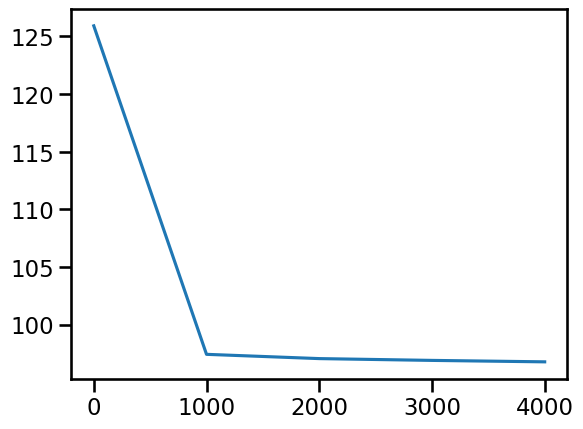

In [21]:
# #------------------------------------------------------------------------------------------------------------------------------------
# # NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 50
lamb = 0.01 
T = 4000     
interval = 1000
batch_size = 0.1
lr = 1e-2
seed = 0
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# #------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

#### inference

In [22]:
# umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 

if True:
    zs = model.extract_cell_factors()
    np.save('./outputs/MB_RNA+ATAC+Histone/zs.npy', zs)
else:
    zs = np.load('./outputs/MB_RNA+ATAC+Histone/zs.npy', allow_pickle=True)
    
# x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

/home/xuhua/xuhua_disco/miniforge3/envs/bento/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [23]:
batches = ['mult1']*ad_mult_rna.n_obs + ['mult2']*ad_mult_rna2.n_obs + ['mult3']*ad_mult_rna3.n_obs + ['mult4']*ad_mult_rna4.n_obs

### eval results

In [25]:
ad_mosaic = sc.AnnData(np.vstack(zs), obsm={"X_emb":np.vstack(zs)})
ad_mosaic.obs['batches'] = np.hstack(batches)

ad_mosaic = get_umap(ad_mosaic, ['X_emb'])

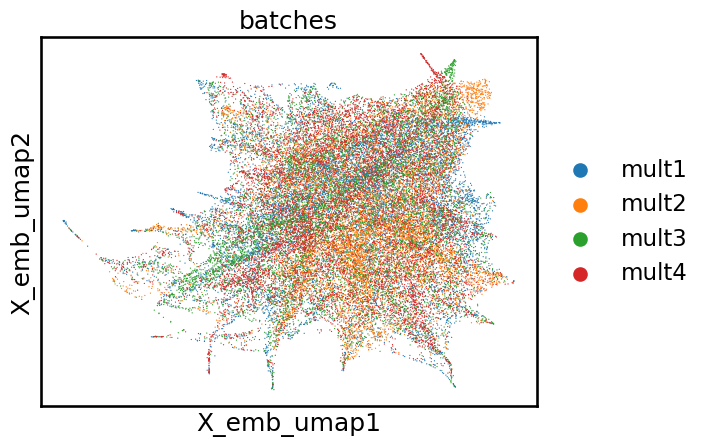

In [26]:
wrap_warn_plot(ad_mosaic, 'X_emb_umap', ['batches'])

### before batch corr

In [29]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['batches'],
    label_keys = [],
    use_rep='X_emb', use_neighbors=False,
)
lisi_res['batches_iLISI'][0]

0.5038745017151117

### after batch corr

In [30]:
from batchCorr import HARMONY

ad_mosaic.obsm['X_emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['X_emb']), ad_mosaic.obs['batches'].to_list())
ad_mosaic = get_umap(ad_mosaic, ['X_emb_har'])
# split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obsm', key='X_emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [32]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['batches'],
    label_keys = [],
    use_rep='X_emb_har', use_neighbors=False,
)
r2 = lisi_res['batches_iLISI'][0]

In [33]:
r2

0.6393429463773118

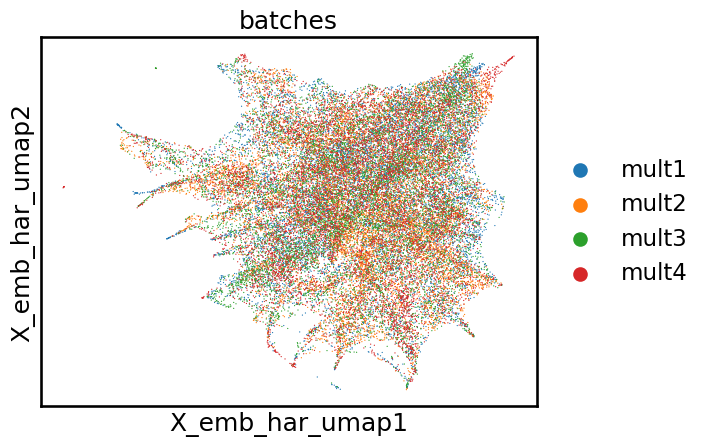

In [34]:
wrap_warn_plot(ad_mosaic, 'X_emb_har_umap', ['batches'])

### Vis

In [36]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/MB_RNA+ATAC+Histone/scmomat'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mult_rna.obs_names.to_list() + ad_mult_rna2.obs_names.to_list() + ad_mult_rna3.obs_names.to_list() + ad_mult_rna4.obs_names.to_list())
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['X_emb_har'], index=ad_mult_rna.obs_names.to_list() + ad_mult_rna2.obs_names.to_list() + ad_mult_rna3.obs_names.to_list() + ad_mult_rna4.obs_names.to_list())
df.to_csv(join(fig_dir, 'X_emb_har.csv'))

In [37]:
1

1